# Modeling Performence Check - baseline model (RandomForestRegression)

## 1) Data Load


In [93]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer, StandardScaler ## minmax(0,1), 이상치 고려, (평균0, 분산1)
from sklearn.feature_selection import VarianceThreshold,RFECV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso

import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle
import sagemaker

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [94]:
data_list = ['booking_df', 'coupon_df', 'flight_df', 'discount_ratio', 'peak_low_season', 'fare_by_class','total_df']
for i in data_list:
    print(f"Data {i} Read Done -----------")
    globals()[i] = pd.read_parquet(f'/root/data/{i}.parquet')

Data booking_df Read Done -----------
Data coupon_df Read Done -----------
Data flight_df Read Done -----------
Data discount_ratio Read Done -----------
Data peak_low_season Read Done -----------
Data fare_by_class Read Done -----------
Data total_df Read Done -----------


## 2) Feature Selection

### - 기본 Feature 선정 및 형태 변환

In [95]:
sel_basic_feature = [
    # 'total_sold_seats', 'before_tss', 'before_ss', 'sold_seats', 'available_seats', 'remain_seats', 'remain_days', ## 판매/잔여 좌석 및 날짜
    'before_ss', 'sold_seats', 'available_seats', 'remain_seats', 'remain_days', ## 판매/잔여 좌석 및 날짜    
    'departure_hour', 'departure_minute', 'departure_time_format_min', ## 출발 시간 관련 포맷별 데이터
    'CJU', 'GMP', ## 출발 위치
    'peak', 'weekday', 'weekend', 'premium', ## 성수기, 평일, 주말, 주말할증
    'departureweekday_0', 'departureweekday_1', 'departureweekday_2', 'departureweekday_3', 'departureweekday_4', 'departureweekday_5', 'departureweekday_6', ## 출발 요일
    'issueweekday_0', 'issueweekday_1', 'issueweekday_2', 'issueweekday_3', 'issueweekday_4', 'issueweekday_5', 'issueweekday_6', ## 구매 요일
    'month_6', 'month_7', 'month_8', ## 출발 월
    'year_2017', 'year_2018', ## 출발 년도
    # 'month_2', 'month_6', 'month_7', 'month_8', ## 출발 월
    # 'year_2017', 'year_2018', 'year_2022', ## 출발 년도
]
      
target = ['fix_fare']

for i in sel_basic_feature:    
    total_df[i] = total_df[i].astype('float32')
    
model_df = total_df[total_df['year'].isin([2017,2018])].copy()
model_df.shape

(706628, 68)

### - Feature Selection 결과

In [96]:
sel_basic_feature = ['before_ss', 'sold_seats', 'available_seats', 'remain_seats',  'remain_days', 'total_sold_seats','cabin_authorised_cap', 
                     'departure_hour', 'departure_minute', 'departure_time_format_min',    
                     'CJU', 'GMP',    
                     'peak', 'weekday', 'weekend', 'premium',
                     'departureweekday_0', 'departureweekday_1', 'departureweekday_2', 'departureweekday_3', 'departureweekday_4', 'departureweekday_5', 'departureweekday_6',
                     'issueweekday_0', 'issueweekday_1', 'issueweekday_2', 'issueweekday_3', 'issueweekday_4', 'issueweekday_5', 'issueweekday_6',
                     'month_2', 'month_6', 'month_7', 'month_8',
                     'year_2017', 'year_2018', 'year_2022']

sel_var_feature = ['before_ss', 'sold_seats', 'available_seats', 'remain_seats', 'remain_days', 'departure_hour', 
                   'departure_minute', 'departure_time_format_min', 'CJU', 'GMP', 'peak', 'weekday', 'weekend', 
                   'month_6', 'month_7', 'month_8', 'year_2017', 'year_2018']

sel_corr_feature = ['weekday', 'weekend', 'peak', 'sold_seats', 'departureweekday_5', 'premium', 'departureweekday_1', 
                    'month_8', 'departureweekday_6', 'before_ss', 'departureweekday_2', 'remain_seats', 'departureweekday_4', 
                    'departureweekday_3', 'year_2018', 'year_2017', 'remain_days', 'month_6', 'month_7']

sel_vif_feature = ['before_ss', 'sold_seats', 'available_seats', 'remain_seats', 'remain_days', 'peak', 'premium']

sel_rf_feature = ['remain_days', 'departure_time_format_min', 'weekday', 'peak', 'remain_seats', 'departure_hour', 
                  'sold_seats', 'before_ss', 'available_seats', 'departureweekday_6', 'departureweekday_4', 'year_2017', 
                  'month_6', 'month_8', 'GMP', 'CJU', 'premium', 'year_2018', 'departure_minute', 'month_7']

## 3) Train/Test Data Split &  Baseline Model 성능 확인

In [97]:
model_df['departure_fare_basis'] = np.where(model_df['peak']==1, 'peak'
                                            , (np.where(model_df['premium']==1, 'premium'
                                                        , np.where(model_df['weekend']==1, 'weekend', 'weekday')
                                                       )
                                              )
                                           )


In [98]:
# dest = [['CJU', 'GMP'], ['CJU'], ['GMP']]
dest = [['GMP']]
month = [[6,7,8], [6], [7], [8]]
option = [['weekday', 'weekend', 'peak', 'premium'], ['weekday'], ['weekend'], ['peak'], ['premium']]
version = ['basic']
# version = ['var', 'corr', 'vif', 'rf']

# dest = [['CJU'], ['GMP']]
# month = [[6], [7], [8]]
# option = [['weekday'], ['weekend'], ['peak'], ['premium']]
# version = ['var', 'corr', 'vif', 'rf']

dest = [['CJU']]
month = [[6,7,8]]
option = [['primium']]
cluster = 1
version = ['var']


results = pd.DataFrame(columns = ['dest', 'month', 'option', 'version', 'cluster', 'train_score', 'train_rmse', 'test_score', 'test_rmse'])

for version_i in version:
    for dest_i in dest:
        for month_i in month:
            for option_i in option:                
                print("="*50)
                print(f'{version_i} - {dest_i} - {month_i} - {option_i}')
                use_feature = globals()[f'sel_{version_i}_feature']

                train_df = model_df[(model_df['startseg'].isin(dest_i))                                        
                                    & (model_df['month'].isin(month_i))
                                    & (model_df['departure_fare_basis'].isin(option_i))
                                    & (model_df['year'] == 2017)].reset_index(drop = True)
                test_df = model_df[(model_df['startseg'].isin(dest_i))                                        
                                    & (model_df['month'].isin(month_i))
                                    & (model_df['departure_fare_basis'].isin(option_i))
                                    & (model_df['year'] == 2018)].reset_index(drop = True)
                
                try:
                    # train_score, train_rmse = RF_MODULE(train_df[use_feature], train_df['fix_fare'], 'train', version_i)                    
                    test_score, test_rmse = RF_MODULE(test_df[use_feature], test_df['fix_fare'], 'test', version_i)
                    temp_df = pd.DataFrame(columns = ['dest', 'month', 'option', 'version', 'cluster', 'train_score', 'train_rmse', 'test_score', 'test_rmse'],
                                               data = [[str(dest_i), str(month_i), str(option_i), version_i, 0, train_score, train_rmse, test_score, test_rmse]])                    
                    results = pd.concat([results, temp_df])
                    
                # try: ## pca, cluster 포함
                #     train_score, train_rmse = RF_MODEL_MODULE(train_df, use_feature, 'train', version_i)
                #     test_score, test_rmse = RF_MODEL_MODULE(test_df, use_feature, 'test', version_i)
                #     for cluster in [0, 1]:
                #         temp_df = pd.DataFrame(columns = ['dest', 'month', 'option', 'version', 'cluster', 'train_score', 'train_rmse', 'test_score', 'test_rmse'],
                #                                data = [[dest_i[0], month_i[0], option_i[0], version_i, cluster, train_score[cluster], train_rmse[cluster], test_score[cluster], test_rmse[cluster]]])
                #         results = pd.concat([results, temp_df])
                
                except Exception as e:
                    print(e)

basic - ['GMP'] - [6, 7, 8] - ['weekday', 'weekend', 'peak', 'premium']


KeyboardInterrupt: 

In [52]:
results.to_csv('basic_results.csv')

## *) Preprocessing (PCA & Clustering)

### - PCA (components = 2)

In [53]:
def PCA_MODULE(data, mode, algorithm):
    data_x = data.copy()
    if mode == 'train':
        ## Fit & Save PCA
        pca = PCA(n_components=2).fit(data_x)                
        with open(f'/root/preprocessing/pca_{algorithm}.pickle', 'wb') as f:
            pickle.dump(pca, f)        
    else:
        ## Load PCA
        with open(f'/root/preprocessing/pca_{algorithm}.pickle', 'rb') as f:
            pca = pickle.load(f)
        ## Transform PCA
    printcipalComponents = pca.transform(data_x)
        ## Return PCA Result as DataFrame
    return pd.DataFrame(data=printcipalComponents, columns = [f'principal_component_{i}' for i in range(len(pca.explained_variance_ratio_))])

### - Clustering (Kmenas)

In [54]:
def CLUSTERING_MODULE(data, k, mode, algorithm):
    data_x = data.copy()    
    if mode == 'train':
        ## Fit & Save KMeans Clustering
        cluster_model = KMeans(n_clusters = k).fit(data_x)
        with open(f'/root/preprocessing/cluster_{algorithm}.pickle', 'wb') as f:
            pickle.dump(cluster_model, f)
    else:
        ## Load KMeans Model
        with open(f'/root/preprocessing/cluster_{algorithm}.pickle', 'rb') as f:
            cluster_model = pickle.load(f)
        ## Transform KMeans
    data_x['cluster'] = cluster_model.predict(data_x)
        ## Return Kmeans Result as DataFrame
    return data_x 

In [55]:
def RF_MODULE(data_x, data_y, mode, algorithm):
    if mode == 'train':        
        rf_model = RandomForestRegressor(random_state=0).fit(data_x, data_y)                                
        with open(f'/root/preprocessing/rf_{algorithm}.pickle', 'wb') as f:
            pickle.dump(rf_model, f)
    else:        
        with open(f'/root/preprocessing/rf_{algorithm}.pickle', 'rb') as f:
            rf_model = pickle.load(f)        
            
    return rf_model.score(data_x, data_y), mean_squared_error(data_y, rf_model.predict(data_x))**0.5

### - RandomForest Modeling

In [56]:
def RF_MODEL_MODULE(data, use_feature, mode, version):
    data_x = data[use_feature].copy()
    data_y = data[['fix_fare']].copy()
    
    ## Preprocessing Fit & Save
    pca_df = PCA_MODULE(data_x, mode, version)    
    clust_df = CLUSTERING_MODULE(pca_df, 2, mode, version)
    score_list = []
    rmse_list = []
    
    if mode == 'train':            
        ## Randomforest regression Fit & Save
        # for i in clust_df['cluster'].unique():
        for i in [0, 1]:
            print(f"CLUSTER {i}")
            ## Split data as cluster
            train_x = clust_df[clust_df['cluster'] == i][list(pca_df)]
            train_y = data_y.iloc[train_x.index.tolist()]   
            
            ## Model Fit & Save                           
            score, rmse = RF_MODULE(train_x, train_y, mode, version)
            # data.loc[train_x.index.tolist(), 'predict'] = pred
            # data.loc[train_x.index.tolist(), 'cluster'] = i
            score_list.append(score)
            rmse_list.append(rmse)
            
            
    else:        
        ## Randomforest regression Load & Transform
        # for i in clust_df['cluster'].unique():
        for i in [0, 1]:
            print(f"CLUSTER {i}")
            ## Split data as cluster
            test_x = clust_df[clust_df['cluster'] == i][list(pca_df)]
            test_y = data_y.iloc[test_x.index.tolist()]['fix_fare']                

            ## Model Load & Transform                            
            score, rmse = RF_MODULE(test_x, test_y, mode, version)
            # data.loc[test_x.index.tolist(), 'predict'] = pred
            # data.loc[test_y.index.tolist(), 'cluster'] = i
            score_list.append(score)
            rmse_list.append(rmse)
            
    return score_list, rmse_list

## Deeplearning

In [57]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend

from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)

2.6.2


In [75]:
dest_i = ['CJU','GMP']
month_i = [6]
option_i = ['weekday']
cluster = 1
version_i = 'var'

In [84]:
dest_i = ['CJU']
month_i = [6,7,8]
option_i = ['premium']
cluster = 1
version_i = 'var'
use_feature = globals()[f'sel_{version_i}_feature']

train_df = model_df[(model_df['startseg'].isin(dest_i))                                        
                    & (model_df['month'].isin(month_i))
                    & (model_df['departure_fare_basis'].isin(option_i))
                    & (model_df['year'] == 2017)].reset_index(drop = True)
test_df = model_df[(model_df['startseg'].isin(dest_i))                                        
                    & (model_df['month'].isin(month_i))
                    & (model_df['departure_fare_basis'].isin(option_i))
                    & (model_df['year'] == 2018)].reset_index(drop = True)

In [85]:
def dnn_pps(data, mode):
    data_x = data[use_feature].copy()
    data_y = data[['fix_fare']].copy()
    pca_df = PCA_MODULE(data_x, mode, version_i)    
    clust_df = CLUSTERING_MODULE(pca_df, 2, mode, version_i)
    clust_df = clust_df[clust_df['cluster'] == cluster][list(pca_df)]
    temp_x = clust_df.copy()
    temp_y = data_y.iloc[clust_df.index]
    return temp_x, temp_y 

In [86]:
train_x, train_y = dnn_pps(train_df, 'train')
test_x, test_y = dnn_pps(test_df, 'test')

In [91]:
train_x.shape

(167, 2)

In [87]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=1))

keras.backend.clear_session()
tf.random.set_seed(1004)
model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=train_x.shape),
    layers.Dense(8, activation='elu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)
]) 

earlystopping = EarlyStopping(monitor='loss', patience=10, min_delta = 10)
model.compile(loss=rmse, optimizer='Adam', metrics=[rmse, 'mse'])

In [88]:
EPOCHS = 500
BATCH_SIZE = 32

history = model.fit(train_x, train_y, epochs=EPOCHS, batch_size = BATCH_SIZE, validation_split=0.2, verbose=1, callbacks=earlystopping)

Epoch 1/500


1/5 [=====>........................] - ETA: 1s - loss: 88062.0938 - rmse: 88062.0938 - mse: 8049127424.0000WARNING:tensorflow:Model was constructed with shape (None, 167, 2) for input KerasTensor(type_spec=TensorSpec(shape=(None, 167, 2), dtype=tf.float32, name='dense_input'), name='dense_input', description="created by layer 'dense_input'"), but it was called on an input with incompatible shape (None, 2).


5/5 [==============================] - 0s 33ms/step - loss: 91270.4062 - rmse: 91270.4062 - mse: 8442930688.0000 - val_loss: 84104.9219 - val_rmse: 84104.9219 - val_mse: 7573076480.0000
Epoch 2/500
5/5 [==============================] - 0s 6ms/step - loss: 91266.0234 - rmse: 91266.0234 - mse: 8442127872.0000 - val_loss: 84100.6094 - val_rmse: 84100.6094 - val_mse: 7572322304.0000
Epoch 3/500
5/5 [==============================] - 0s 6ms/step - loss: 91261.4844 - rmse: 91261.4844 - mse: 8441293824.0000 - val_loss: 84096.1953 - val_rmse: 84096.1953 - val_mse: 7571548672.0000
Epoch 4/500
5/5 [==============================] - 0s 5ms/step - loss: 91256.8516 - rmse: 91256.8516 - mse: 8440449536.0000 - val_loss: 84091.5859 - val_rmse: 84091.5859 - val_mse: 7570740736.0000
Epoch 5/500
5/5 [==============================] - 0s 5ms/step - loss: 91252.0000 - rmse: 91252.0000 - mse: 8439559680.0000 - val_loss: 84086.7344 - val_rmse: 84086.7344 - val_mse: 7569889792.0000
Epoch 6/500
5/5 [=========

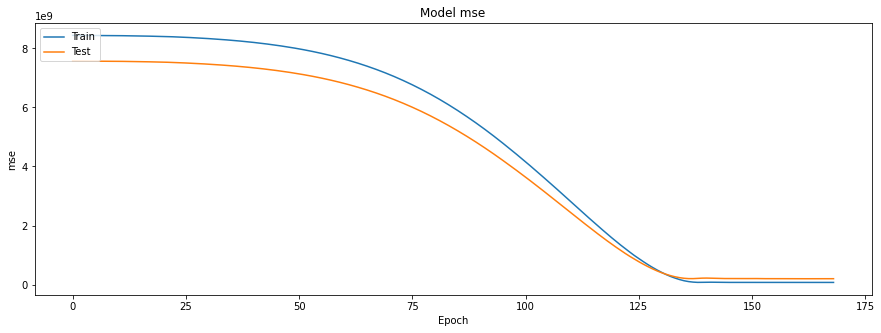

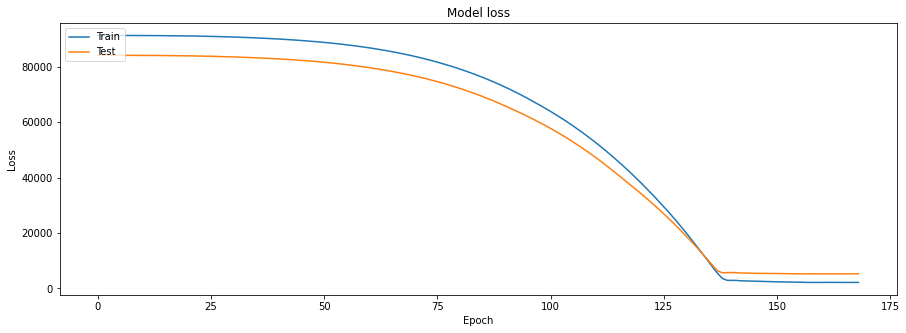

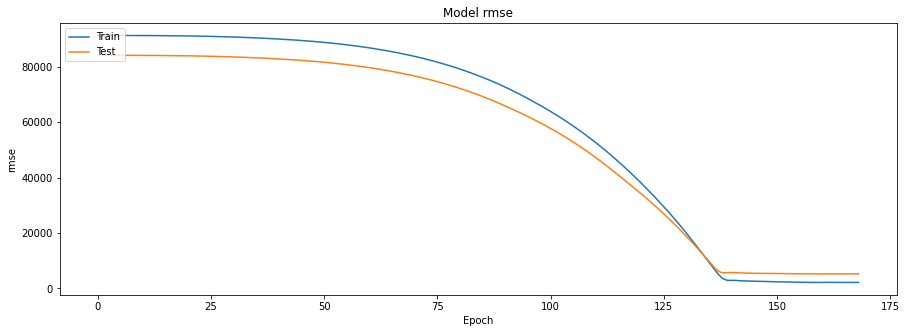

In [89]:
# 6 훈련 과정 시각화 (정확도)
plt.figure(figsize = (15,5))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model mse')
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure(figsize = (15,5))
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model rmse')
plt.xlabel('Epoch')
plt.ylabel('rmse')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [90]:
print("TRAIN")
print(r2_score(train_y, model.predict(train_x)))
print(mean_squared_error(train_y, model.predict(train_x))**0.5)
print("TEST")
print(r2_score(test_y, model.predict(test_x)))
print(mean_squared_error(test_y, model.predict(test_x))**0.5)

TRAIN


0.5119473404307282
9876.675681972669
TEST
0.07736803606951137
10178.813304696989
